# Linear regression

Model relationship between two variables in a linear approach:

$$y^{(i)} = b_0 + b_1\,x^{(i)}$$

## Matplotlib

There are several common approaches to plotting with Matplotlib, here we will use
only the object-oriented API. 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

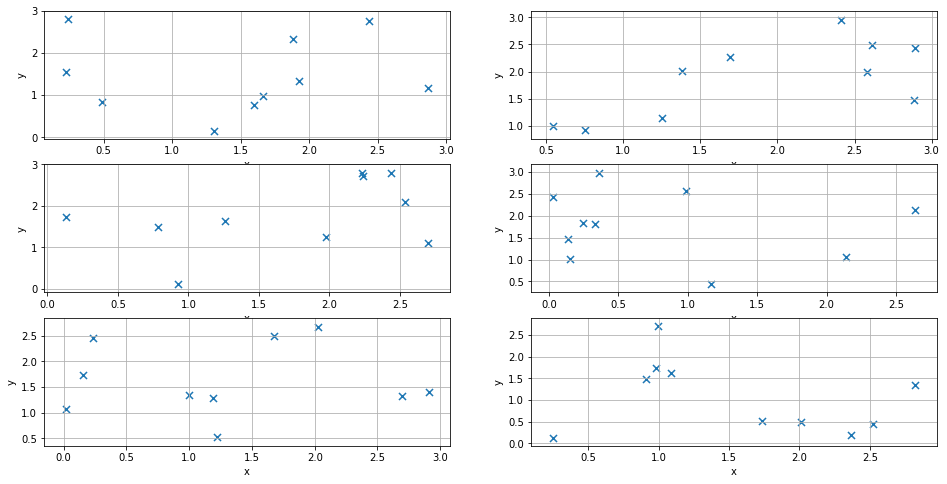

In [2]:
# subplots(n_rows, n_cols) creates a figure with subplots
fig, axes = plt.subplots(3, 2)

# axes is a numpy array
# we will discuss numpy later
for _, ax in np.ndenumerate(axes):
    random_x = [random.uniform(0, 3) for _ in range(10)]
    random_y = [random.uniform(0, 3) for _ in range(10)]
    ax.scatter(
        random_x,
        random_y,
        marker='x',
        s=50
    )
    ax.set(
        xlabel='x',
        ylabel='y',
    )
    ax.grid()
fig.set_size_inches(w=16, h=8)

Let's generate some random points and plot them

In [3]:
def random_x_y(points):
    b0 = random.uniform(-1, 1)
    b1 = random.uniform(1, 3)
    x = [random.uniform(0, 3) for _ in range(points)]
    # to every yi, add some error between (-1, 1)
    y = [
        b0 + b1*xi + random.uniform(-1, 1)
        for xi in x
    ]
    # Using linear regression, our goal is to find
    # b0 and b1. We return also the used b0 and b1,
    # so that we can later compare it to our estimations
    return x, y, b0, b1

In [4]:
x, y, b0, b1 = random_x_y(20)

# We also would like to plot the exact
# linear relationship
x_ideal = [0.1 * i for i in range(30)]
y_ideal = [
    b0 + b1*xi
    for xi in x_ideal
]

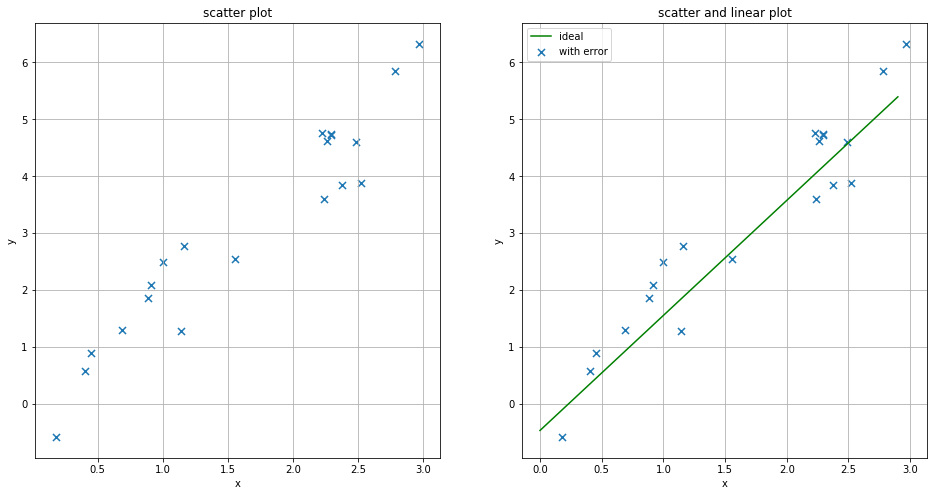

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(
    x, 
    y,
    marker='x',
    s=50
)
ax1.set(
    xlabel='x',
    ylabel='y',
    title='scatter plot'
)
ax1.grid()

ax2.scatter(
    x,
    y,
    marker='x',
    s=50,
    label='with error'
)
ax2.plot(
    x_ideal, 
    y_ideal, 
    'g',
    label='ideal'
)
ax2.set(
    xlabel='x',
    ylabel='y',
    title='scatter and linear plot'
)
ax2.grid()
ax2.legend()

fig.set_size_inches(w=16, h=8)

## Error function
We are going to predict $b_0$ and $b_1$. In order to know how good our estimates are,
we need an error function which tells us how big is our error. Let $m$ be the number
of sample points, $h(x^{i})$ the current estimate and $x^{(i)}, y^{(i)}$ a point from our sample.
$$J = \frac{1}{2m}\sum_{i=0}^{m} \left(h(x^{(i)}) - y^{(i)}\right)^2$$

$$h(x^{(i)}) = b_0 + b_1\,x^{(i)}$$

In [6]:
# b0 and b1 are our estimates
def compute_error(x, y, b0, b1):
    def h(xi):
        return b0 + b1*xi

    m = len(x)
    return 1 / (2*m) * sum(
        (h(x[i]) - y[i]) ** 2
        for i in range(m)
    )

Let's display this error function. First for $b_0 = const.$ over $b_1$

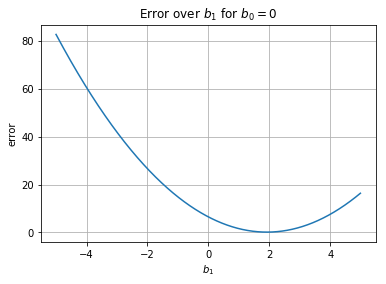

In [7]:
b1_points = [0.01 * i for i in range(-500, 500)]
b0_const = 0
error_values = [
    compute_error(x, y, b0_const, b1_point)
    for b1_point in b1_points
]

fig, ax = plt.subplots()
ax.plot(b1_points, error_values)
ax.set(
    xlabel=r'$b_1$',
    ylabel='error',
    title=r'Error over $b_1$ for $b_0 = 0$'
)
ax.grid()

Now as a contour plot for different $b_0$ and $b_1$

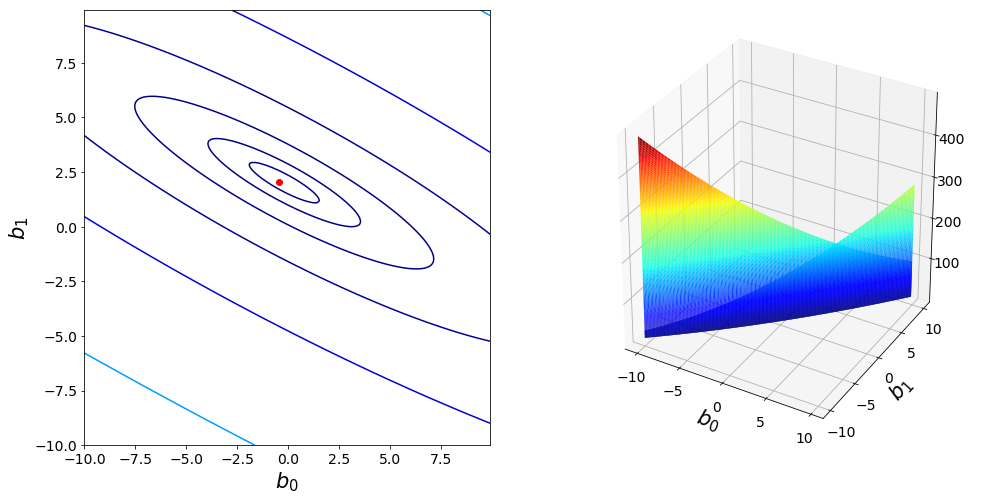

In [8]:
b0_points = [0.1*i for i in range(-100, 100)]
b1_points = [0.1*i for i in range(-100, 100)]

error_values = [
    [
        compute_error(x, y, b0_point, b1_point)
        for b0_point in b0_points
    ]
    for b1_point in b1_points
]

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.contour(
    b0_points, 
    b1_points, 
    error_values, 
    np.logspace(-2, 3, 10),
    cmap=plt.cm.jet
)
ax1.scatter(b0, b1, c='r')

ax2.plot_surface(
    b0_points, 
    b1_points,
    np.asarray(error_values),
    rstride=1, cstride=1,
    cmap=plt.cm.jet
)

for ax in fig.axes:
    ax.set_xlabel(r'$b_0$', fontsize=21)
    ax.set_ylabel(r'$b_1$', fontsize=21)
    
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(14)
        
ax2.set_xticks([-10, -5, 0, 5, 10])
ax2.set_yticks([-10, -5, 0, 5, 10])

for label in (ax2.get_xticklabels() + ax2.get_yticklabels() + ax2.get_zticklabels()):
    label.set_fontsize(14)

The goal is to find $b_0$ and $b_1$ so that the error function minimizes. We will do this by taking a step proportional to the negative gradient of the error function. This iterative optimization approach is known as gradient descent. Fist, we have to calculate its derivatives:

$$
\frac{\partial J}{\partial b_0} = \frac{1}{m} \sum_{i=0}^{m} \left(h(x^{(i)}) - y^{(i)}\right)
$$
$$
\frac{\partial J}{\partial b_1} = \frac{1}{m} \sum_{i=0}^{m} x^{(i)} \left(h(x^{(i)}) - y^{(i)}\right)
$$

At each step we re-calculate $b_0$ and $b_1$:

$$
b_0 \leftarrow b_0 - \alpha \frac{\partial J}{\partial b_0}
$$
$$
b_1 \leftarrow b_1 - \alpha \frac{\partial J}{\partial b_1}
$$

In [9]:
def gradient_descent(x, y, b0=0, b1=0, alpha=0.01, num_iters=100):
    error_history = [compute_error(x, y, b0, b1)]
    
    m = len(x)
    for _ in range(num_iters):
        b0_new = b0 - alpha * 1 / m * sum([
            b0 + b1 * x[i] - y[i]
            for i in range(m)
        ])
        b1_new = b1 - alpha * 1 / m * sum([
            x[i] * (b0 + b1 * x[i] - y[i])
            for i in range(m)
        ])
        b0, b1 = b0_new, b1_new
        
        error_history.append(compute_error(x, y, b0, b1))
    return b0, b1, error_history

error with actual b0, b1:  0.17468188301094398
error with predicted b0, b1:  0.2152895062795341


[Text(0, 0.5, 'error'),
 Text(0.5, 0, 'steps'),
 Text(0.5, 1.0, 'History of error function')]

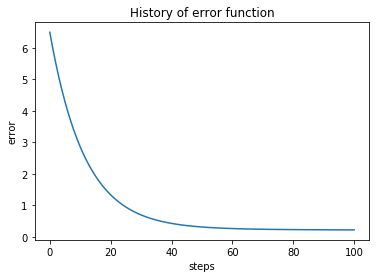

In [10]:
pred_b0, pred_b1, error_history = gradient_descent(x, y)

print('error with actual b0, b1: ', compute_error(x, y, b0, b1))
print('error with predicted b0, b1: ', compute_error(x, y, pred_b0, pred_b1))

fig, ax = plt.subplots()
ax.plot(error_history)
ax.set(
    xlabel='steps',
    ylabel='error',
    title='History of error function'
)

When we have more than one variable $x$ (i.e. $x_1, x_2, ..., x_n$), the linear regression function takes
the following form:
$$
y^{(i)} = b_0 + \sum_{k=1}^{n}b_k\,x_k^{(i)}
$$

In such a case matrix notation comes handy ($x_0^{(i)} = 1$):

$$
X = \left(
    \begin{matrix} 
    x_0^{(1)} & ... & x_n^{(1)} \\ 
    \vdots & \ddots & \vdots \\
    x_0^{(m)} & ... & x_n^{(m)}
    \end{matrix}
    \right)
$$

$$
y = \left(
    \begin{matrix} 
    y^{(1)} \\
    \vdots \\
    y^{(m)}
    \end{matrix}
    \right)
$$

$$
b = \left(
    \begin{matrix} 
    b_0 \\
    \vdots \\
    b_m
    \end{matrix}
    \right)
$$

So:

$$
y = Xb
$$

Hence, the error function:

$$
J = \frac{1}{2m}(Xb - y)^T(Xb - y)
$$

And its gradient:

$$
\frac{\partial J}{\partial b} = \frac{1}{m} X^T \left( Xb - y \right) 
$$

So the gradient descent step is:

$$
b \leftarrow b - \alpha \frac{\partial J}{\partial b}
$$

Let's write a class for the linear regression:

In [11]:
class LinearRegression(object):
    
    def __init__(self):
        self._num_iter_steps = 1000
        self._step_size = 0.01
        self._b = None
        
    def fit(self, X, y):
        n, m = X.shape
        # Add 1 to account for b0
        self._b = np.zeros((m + 1, 1))
        
        # add column of ones for x0
        X = self.add_ones(X)

        for _ in range(self._num_iter_steps):
            self._b = self._b - self._step_size / m * X.T.dot(X.dot(self._b) - y)
        
        return self
    
    @staticmethod
    def add_ones(X):
        n, _ = X.shape
        ones_column = np.ones((n, 1))
        return np.concatenate((ones_column, X), axis=1)
    
    def predict(self, X):
        X = self.add_ones(X)
        return X.dot(self._b)

In [12]:
X = np.asarray(x).reshape((-1, 1))
y_vec = np.asarray(y).reshape((-1, 1))

In [13]:
reg = LinearRegression().fit(X, y_vec)
y_pred = reg.predict(X)

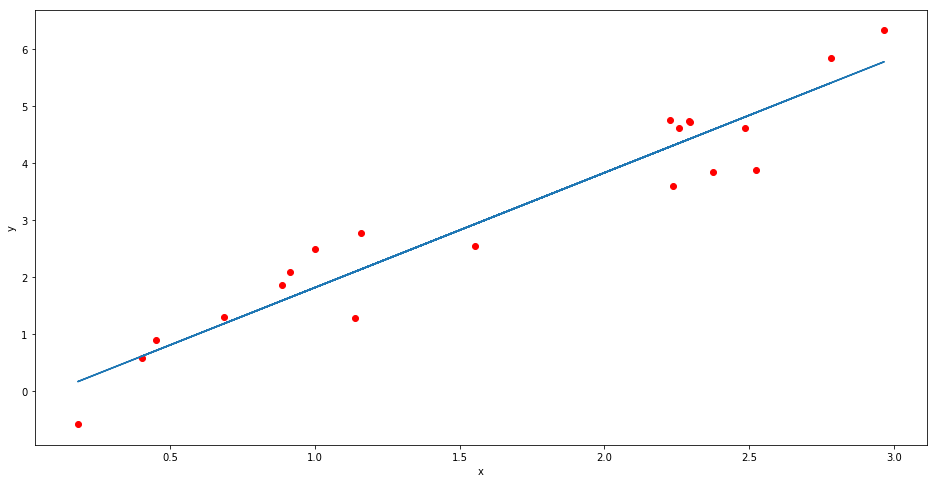

In [14]:
fig, ax = plt.subplots()
ax.scatter(x, y, c='r')
ax.plot(x, y_pred)
ax.set(
    xlabel='x',
    ylabel='y'
)

fig.set_size_inches(w=16, h=8)

There is also an analytical solution to the linear regression problem. We saw that the derivate of the error function is:

$$
\frac{\partial J}{\partial b} = \frac{1}{m} X^T \left( Xb - y \right) 
$$

Since we are looking for its minimum, we set it to 0:

$$
\frac{\partial J}{\partial b} = X^TXb - X^Ty = 0
$$

$$
X^TXb = X^Ty
$$

$$
b = (X^TX)^{-1}X^Ty
$$

This works fine too, however, $X^TX$ has to be invertible. $X^TX$ can be non-invertible for linearly dependent (i.e. redundant features), so when the columns of $X$ are linearly dependent. For example, for a house price prediction problem, the area of the house can be given in both square-feets and square-meters.
Consider the following example:

$$
X = \left(
    \begin{matrix} 
    1 & 2 & 4 \\
    1 & 3 & 6 \\
    1 & 4 & 8
    \end{matrix}
    \right)
$$

The third column is the second column times 2. For this $X$, $X^TX$ will be a singular, a non-invertible matrix:

In [15]:
from numpy.linalg import inv

X_lin_dep = np.array([
    [1, 2, 4],
    [1, 3, 6],
    [1, 4, 8]
])

XTX = X_lin_dep.T.dot(X_lin_dep)
XTX_inv = inv(XTX)

LinAlgError: Singular matrix